In [1]:
import sqlite3
import numpy as np
import pandas as pd

## Creating Helper Functions

In [2]:
# Define a function to run a SQL query within a context manager
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q,conn)

In [3]:
# Define a function to run a command within a context manager
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
# Define a function to show tables within context
def show_tables():
    q = "SELECT name, type FROM sqlite_master WHERE type IN ('table', 'view');"
    return run_query(q)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Most Popular Genre in USA

In [6]:
# Query to return each genre, with number of tracks sold
albums_to_purchase = '''

WITH usa_tracks_sold AS
    (
    SELECT 
        il.*
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id=il.invoice_id
    INNER JOIN customer c ON c.customer_id=i.customer_id
    WHERE c.country='USA'
    )
SELECT
    g.name AS genre,
    COUNT(uts.track_id) as number_of_tracks,
    cast(COUNT(uts.track_id) AS FLOAT)/ (SELECT COUNT(*) FROM usa_tracks_sold) AS percentage
    FROM usa_tracks_sold uts
    INNER JOIN track t ON uts.track_id=t.track_id
    INNER JOIN genre g ON g.genre_id=t.genre_id
    GROUP BY genre
    ORDER BY number_of_tracks DESC
    LIMIT 10
    
   
'''
run_query(albums_to_purchase)

,genre,number_of_tracks,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


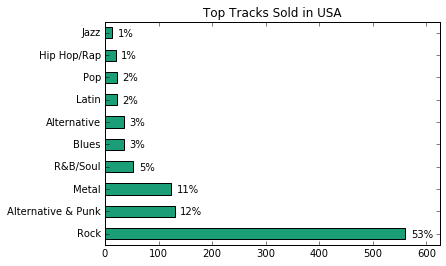

In [7]:
# Plot counts of tracks sold per genre as percentage
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", inplace=True, drop=True)
genre_sales_usa["number_of_tracks"].plot.barh(
    title="Top Tracks Sold in USA",
    xlim = (0,625),
    colormap = plt.cm.Dark2
)
plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "number_of_tracks"]
    label = (genre_sales_usa.loc[label, "percentage"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15)) # gives some white space for label

plt.show()

Rock is the most popular genre followed by Alternative&Punk and Metal in the USA. Given, Pop is more popular than Hip Hop/Rap, I would recommend Red Tone(Punk), Slim Jim Bites(Blues) and Meteor and the Girls(Pop). 

## Sales Agent Performance

In [8]:
# Query to find the total dollar amount of sales assigned to each sales support agent
support_agent_total_sales = '''

WITH total_sales AS
    (
    SELECT 
        c.customer_id AS customer,
        SUM(i.total) AS customer_sales,
        c.support_rep_id
    FROM invoice i
    INNER JOIN customer c ON c.customer_id=i.customer_id
    GROUP BY c.customer_id
    )
SELECT
    first_name || " " || last_name AS employee_name,
    ROUND(SUM(customer_sales),2) AS support_agent_sales,
    hire_date
    FROM total_sales t
    INNER JOIN employee e ON e.employee_id=t.support_rep_id
    WHERE title = 'Sales Support Agent'
    GROUP BY employee_name
    ORDER BY support_agent_sales DESC
    LIMIT 10
    
   
'''
run_query(support_agent_total_sales)

,employee_name,support_agent_sales,hire_date
0,Jane Peacock,1731.51,2017-04-01 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00


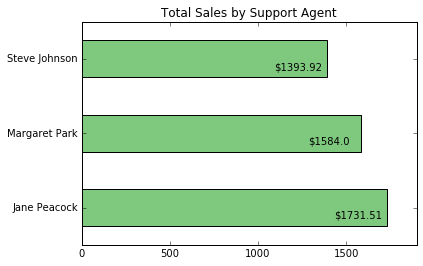

In [9]:
support_agent_sales = run_query(support_agent_total_sales)
support_agent_sales.set_index("employee_name", inplace=True, drop=True)
support_agent_sales.sort_values("support_agent_sales", ascending = False)
support_agent_sales["support_agent_sales"].plot.barh(
    title="Total Sales by Support Agent",
    xlim = (0,1900),
    colormap = plt.cm.Accent
)
plt.ylabel('')

for i, label in enumerate(list(support_agent_sales.index)):
    score = support_agent_sales.loc[label, "support_agent_sales"]
    plt.annotate("$" + str(score), (score - 300, i - 0.15))

plt.show()

Jane has the most amount of sales, followed by Margaret and Steve. However, the above sales amount does not take into account the fact that each employee has different start dates. Further analysis could look into sales amount from a specific range of time to compare sales performance equally across time. 

## Sales by Country 

In [10]:
c='''

CREATE VIEW countrysales_a AS 
    select c.country, 
           i.total, 
           i.customer_id
        from customer c 
        left join invoice i on c.customer_id=i.customer_id
        ;
        '''

run_command(c)


OperationalError: table countrysales_a already exists

In [ ]:
sales_by_country_1='''
WITH country_or_other AS 
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       i.*
     FROM invoice i 
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )
    
    
SELECT 
    country,
    customers, 
    total_sales, 
    avg_sales_per_customer, 
    avg_order_value
FROM 
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        sum(total) total_sales, 
        sum(total)/count(distinct customer_id) avg_sales_per_customer, 
        sum(total)/count(invoice_id) avg_order_value,
        CASE 
            WHEN country="Other" THEN 1
            ELSE 0
        END AS sort,
        count(customer_id) AS total_number_of
    FROM country_or_other
    GROUP BY country
ORDER BY sort ASC, total_sales DESC
    ); 
'''



run_query(sales_by_country_1)

In [ ]:
# Create visualizations for country metrics

country_metrics = run_query(sales_by_country_1)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    title='Pct Customers and Sales per Country',
    colormap=plt.cm.Accent    
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# bottom left
average_order=country_metrics["avg_order_value"].copy()
average_order.index.name=''
difference_from_avg = average_order * 100 / average_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(True)

# bottom right
ltv=country_metrics["avg_sales_per_customer"].copy()
ltv.index.name=''
ltv.drop("Other", inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.axhline(0, color='k')
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
ax4.spines["bottom"].set_visible(True)

plt.show()

Czech Republic, UK, and India seem to have higher orders than average and would be interesting to follow for growth potential. However, the sample size is quite small so this may not be representative. More data would be useful to make a better recommendation for marketing.


### How many invoices bought the whole album?

In [ ]:
albums_versus_tracks='''


with ifs as 
(
select il.invoice_id,
       min(il.track_id) as first_track_id
       from invoice_line il
       group by il.invoice_id
       )
       
select album_purchase, 
       count(invoice_id) as number_of_invoices,
       cast(count(invoice_id) as float)/(select count(*) from invoice) as percentage
from (
 
select ifs.*, 

CASE WHEN 
(
select il2.track_id 
from invoice_line il2
where ifs.invoice_id=il2.invoice_id

except 

select track_id 
from track t
where t.album_id =(select t2.album_id from track t2 where t2.track_id=ifs.first_track_id)
)
IS NULL 


AND

(
select track_id
from track t
where t.album_id=(select t2.album_id from track t2 where t2.track_id=ifs.first_track_id)

except 

select il2.track_id
from invoice_line il2
where ifs.invoice_id=il2.invoice_id
) IS NULL 

THEN "Yes"
ELSE "No"
END AS "album_purchase"

FROM ifs

)
group by album_purchase

'''
    

run_query(albums_versus_tracks)

Album purchases make up 20% of the store's sales. I would suggest against the trying the new strategy for buying only the popular tracks from albums as the store would lose 20% of the revenue.

### Percentage of tracks that have not been purchased

In [ ]:
tracks_unpurchased='''
with a as (
select distinct(track_id) 
from track t

except 

select distinct(track_id)
from invoice_line il
)

select count(*) as unpurchased_tracks, 
       cast(count(*) as float)/(select count(distinct(track_id)) from track) as percentage
from a 
order by track_id

'''


run_query(tracks_unpurchased)

It seems like the store may need to take an alternative approach to buying tracks from record companies as 48% of their inventory of tracks have never been purchased. Since they have been purchasing albums from record companies, this suggests that some of the tracks on albums never get purchased by customers and the popular songs on the albums are sold as single tracks. I would suggest that the store only purchase the tracks that are popular with customers and open up inventory for more classical tracks as well.

### Which artist is used in the most playlists?

In [13]:
playlist_appearance='''
select a2.name, 
       count(a2.name) as appearance_count
from playlist_track pt
inner join track t on t.track_id=pt.track_id
inner join album a on a.album_id=t.album_id
inner join artist a2 on a2.artist_id=a.artist_id
group by a2.name
order by 2,1
'''


run_query(playlist_appearance)

,name,appearance_count
0,Aaron Goldberg,2
1,Aquaman,2
2,Cake,2
3,Calexico,2
4,Luciana Souza/Romero Lubambo,2
5,Dread Zeppelin,3
6,Nicolaus Esterhazy Sinfonia,3
7,Aaron Copland & London Symphony Orchestra,4
8,Academy of St. Martin in the Fields Chamber En...,4
9,"Academy of St. Martin in the Fields, John Birc...",4


In [22]:
max_playlist_appearance='''
select a2.name, 
       count(a2.name) as appearance_count
from playlist_track pt
inner join track t on t.track_id=pt.track_id
inner join album a on a.album_id=t.album_id
inner join artist a2 on a2.artist_id=a.artist_id
group by a2.name
order by 2 desc
limit 1
'''

run_query(max_playlist_appearance)

,name,appearance_count
0,Iron Maiden,516
